# How To Not Do Time Series Classification

This past year we have been working with time series data from the health domain.
Well known examples of time series data from the health domain are ECG readings, EEG readings, traces of position of a person's hand during motion.
As with these examples, our data was extracted from a system which would exhibit different dynamics, thus giving different kinds of time series depending on its dynamics. These different dynamics were the different classes or categories that the uystem could be in. And the idea was that the system could transition between these different classes. So, the time series could change dynamically.

Consider the following plots as different ECG signals [2], corresponding to different classes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

In [3]:
labels = ['Normal beat','Supraventricular premature beat',
            'Premature ventricular contraction','Fusion of ventricular and normal beat',
            'Unclassifiable beat']
# From [2]

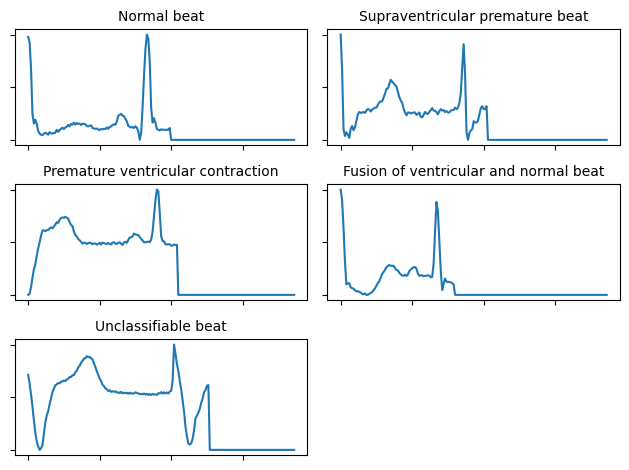

In [4]:
fig = plt.figure()
ax0 = fig.add_subplot(321)
ax1 = fig.add_subplot(322)
ax2 = fig.add_subplot(323)
ax3 = fig.add_subplot(324)
ax4 = fig.add_subplot(325)
ax = [ax0, ax1, ax2, ax3, ax4]
for ii in range(5):
    ts = df_train[df_train[187]==ii].iloc[0].values[:187]
    ax[ii].plot(ts)
    ax[ii].set_title(labels[ii], fontsize=10)
    ax[ii].set_xticklabels([])
    ax[ii].set_yticklabels([])
plt.tight_layout()
plt.show()

One of the basic questions we wanted to ask the data was: can we dynamically measure the change in class of the time seires? In other words, can we tell when the time series changes from one category to another? 

This lead to a few more questions: Would this be a simple classification task, given the nature of our data? What kind of training data would we need?

Let's deal with one of our questions: Is this a usual classification task and can we use a trusty `sklearn` classifier to do the job?

Well, it's not as easy as that.

It turns out that in order to use `sklearn` classifiers, we have to consider each data point in the time series as a separate feature, and effectively forget that these points are ordered in time. In other words, `sklearn` classifiers ignore the sequence information in the variables. If the order of these features was changed, say by randomizing the time series, the fitted model and predictions might not change. This might not fly with our particular time series classification use case.

Let's see how well an `sklearn` classifier does.

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
df_train.shape, df_test.shape

((87554, 188), (21892, 188))

The training data is too large for a quick and dirty calculation. So, let me take a subset.

In [7]:
a0 = df_train[df_train[187]==0][:500].values[:,:-1]
a1 = df_train[df_train[187]==1][:500].values[:,:-1]
a2 = df_train[df_train[187]==2][:500].values[:,:-1]
a3 = df_train[df_train[187]==3][:500].values[:,:-1]
a4 = df_train[df_train[187]==4][:500].values[:,:-1]

X_train = np.append(a0, a1, axis=0)
X_train = np.append(X_train, a2, axis=0)
X_train = np.append(X_train, a3, axis=0)
X_train = np.append(X_train, a4, axis=0)

y_train = [0]*500 + [1]*500 + [2]*500 + [3]*500 + [4]*500

In [8]:
ecg_df_train = pd.DataFrame(X_train, columns=[f"feature{ff}" for ff in range(187)])
ecg_df_train["y"] = y_train

In [9]:
# Shuffle train dataset:
ecg_df_train = ecg_df_train.sample(frac=1)
ecg_df_train.reset_index(drop=True, inplace=True)

In [10]:
X_train = ecg_df_train[[f"feature{ff}" for ff in range(187)]].values
y_train = ecg_df_train["y"].values

In [11]:
b0 = df_test[df_test[187]==0][:100].values[:,:-1]
b1 = df_test[df_test[187]==1][:100].values[:,:-1]
b2 = df_test[df_test[187]==2][:100].values[:,:-1]
b3 = df_test[df_test[187]==3][:100].values[:,:-1]
b4 = df_test[df_test[187]==4][:100].values[:,:-1]

X_test = np.append(b0, b1, axis=0)
X_test = np.append(X_test, b2, axis=0)
X_test = np.append(X_test, b3, axis=0)
X_test = np.append(X_test, b4, axis=0)

y_test = [0]*100 + [1]*100 + [2]*100 + [3]*100 + [4]*100

In [12]:
ecg_df_test = pd.DataFrame(X_test, columns=[f"feature{ff}" for ff in range(187)])
ecg_df_test["y"] = y_test

In [13]:
# Shuffle test dataset:
ecg_df_test = ecg_df_test.sample(frac=1)
ecg_df_test.reset_index(drop=True, inplace=True)

In [14]:
X_test = ecg_df_test[[f"feature{ff}" for ff in range(187)]].values
y_test = ecg_df_test["y"].values

In [15]:
rand_forest = RandomForestClassifier(n_estimators=100)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       100
           1       0.92      0.85      0.89       100
           2       0.88      0.86      0.87       100
           3       0.83      0.89      0.86       100
           4       0.98      0.90      0.94       100

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500



What if I shuffle up the order of the time series, and repeat the above process?

In [16]:
import random

In [17]:
feature_order = [f"feature{ff}" for ff in range(187)]
random.shuffle(feature_order)

In [18]:
X_train = ecg_df_train[feature_order].values
X_test = ecg_df_test[feature_order].values

In [19]:
rand_forest = RandomForestClassifier(n_estimators=100)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       100
           1       0.93      0.82      0.87       100
           2       0.87      0.85      0.86       100
           3       0.85      0.89      0.87       100
           4       0.99      0.90      0.94       100

    accuracy                           0.86       500
   macro avg       0.87      0.86      0.86       500
weighted avg       0.87      0.86      0.86       500



Even after we broke the order of the time series, the accuracy is the same. Does this make sense?

We need a classifier that maintains the sequential nature of the time series.

More on this next time.

References:
1. https://github.com/mloning/intro-to-ml-with-time-series-workshop-2023/blob/main/notebooks/classification/classification.ipynb
2. https://www.kaggle.com/datasets/shayanfazeli/heartbeat